<a href="https://colab.research.google.com/github/shresthasubham/gpt2-fromScratch/blob/master/077BCT082_gptfromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Required Libraries

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F  # Import functional API for activation functions and loss computations


Hyperparameters

In [ ]:
# Define various hyperparameters used throughout the script
batch_size = 16   # Number of parallel sequences processed in a batch
block_size = 32   # Maximum length of context for predictions
max_iters = 5000  # Total number of training iterations
eval_interval = 100  # How often to evaluate the model on validation data
learning_rate = 1e-3  # Learning rate for optimization
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available
eval_iters = 200  # Number of iterations for loss estimation
n_embd = 64  # Embedding size for token representations
n_head = 4  # Number of attention heads in multi-head self-attention
n_layer = 4  # Number of transformer layers
dropout = 0.0  # Dropout probability for regularization


##Load and Preprocess Data

We load the text file, process unique characters, and convert them into numerical format.

In [ ]:
# dataset to train is  tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-02-26 07:37:07--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2025-02-26 07:37:08 (46.4 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# Set a random seed for reproducibility
torch.manual_seed(1337)

# Load the text data
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Extract unique characters from the dataset
chars = sorted(list(set(text)))
vocab_size = len(chars)  # Size of the vocabulary

# Create character-to-index and index-to-character mappings
stoi = {ch: i for i, ch in enumerate(chars)}  # String to index
itos = {i: ch for i, ch in enumerate(chars)}  # Index to string

# Encoding function: Converts a string into a list of integers
encode = lambda s: [stoi[c] for c in s]

# Decoding function: Converts a list of integers back into a string
decode = lambda l: ''.join([itos[i] for i in l])

# Convert the entire dataset into a tensor of integer values
data = torch.tensor(encode(text), dtype=torch.long)

# Split dataset into training (90%) and validation (10%) sets
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


Batch Data Loader : generates small batches of input (x) and target (y) sequences for training.

In [ ]:
# Function to create mini-batches for training or validation
def get_batch(split):
    data = train_data if split == 'train' else val_data  # Choose dataset based on split
    ix = torch.randint(len(data) - block_size, (batch_size,))  # Random starting indices
    x = torch.stack([data[i:i+block_size] for i in ix])  # Input sequence
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])  # Target sequence (next token prediction)
    return x.to(device), y.to(device)


 ## Loss Estimation Function


 computes the average loss over multiple batches to evaluate model performance

In [ ]:
@torch.no_grad()  # Disable gradient calculations for efficiency
def estimate_loss():
    out = {}
    model.eval()  # Set model to evaluation mode
    for split in ['train', 'val']:  # Compute loss for both training and validation sets
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)  # Forward pass through model
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  # Switch model back to training mode
    return out


## Self-Attention Mechanism
 model focus on relevant parts of input sequences for better predictions.

In [ ]:
class Head(nn.Module):
    """ Implements a single head of self-attention. """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)  # Key projection
        self.query = nn.Linear(n_embd, head_size, bias=False)  # Query projection
        self.value = nn.Linear(n_embd, head_size, bias=False)  # Value projection
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))  # Lower triangular mask
        self.dropout = nn.Dropout(dropout)  # Dropout for regularization

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)

        # Compute scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # Mask future tokens
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v
        return out


## Multi-Head Attention

to learn multiple representations of the input simultaneously

In [ ]:
class MultiHeadAttention(nn.Module):
    """ Implements multi-head self-attention. """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)  # Linear projection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # Concatenate multiple heads
        return self.dropout(self.proj(out))


## Transformer Block
This forms the core computational block in Transformer models, combining attention and feedforward layers.

In [ ]:
class Block(nn.Module):
    """ Implements a single Transformer block. """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


 ## Language Model

In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

## Train and Generate

In [ ]:
model = BigramLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))


step 0: train loss 4.4046, val loss 4.4061
step 100: train loss 2.6979, val loss 2.7039
step 200: train loss 2.5119, val loss 2.5262
step 300: train loss 2.4343, val loss 2.4446
step 400: train loss 2.3623, val loss 2.3686
step 500: train loss 2.3102, val loss 2.3374
step 600: train loss 2.2626, val loss 2.2877
step 700: train loss 2.2223, val loss 2.2363
step 800: train loss 2.1691, val loss 2.1929
step 900: train loss 2.1304, val loss 2.1621
step 1000: train loss 2.0908, val loss 2.1342
step 1100: train loss 2.0639, val loss 2.1163
step 1200: train loss 2.0375, val loss 2.0929
step 1300: train loss 2.0223, val loss 2.0819
step 1400: train loss 2.0002, val loss 2.0567
step 1500: train loss 1.9770, val loss 2.0376
step 1600: train loss 1.9410, val loss 2.0340
step 1700: train loss 1.9256, val loss 2.0083
step 1800: train loss 1.9143, val loss 2.0111
step 1900: train loss 1.8895, val loss 1.9839
step 2000: train loss 1.8764, val loss 1.9732
step 2100: train loss 1.8628, val loss 1.9710


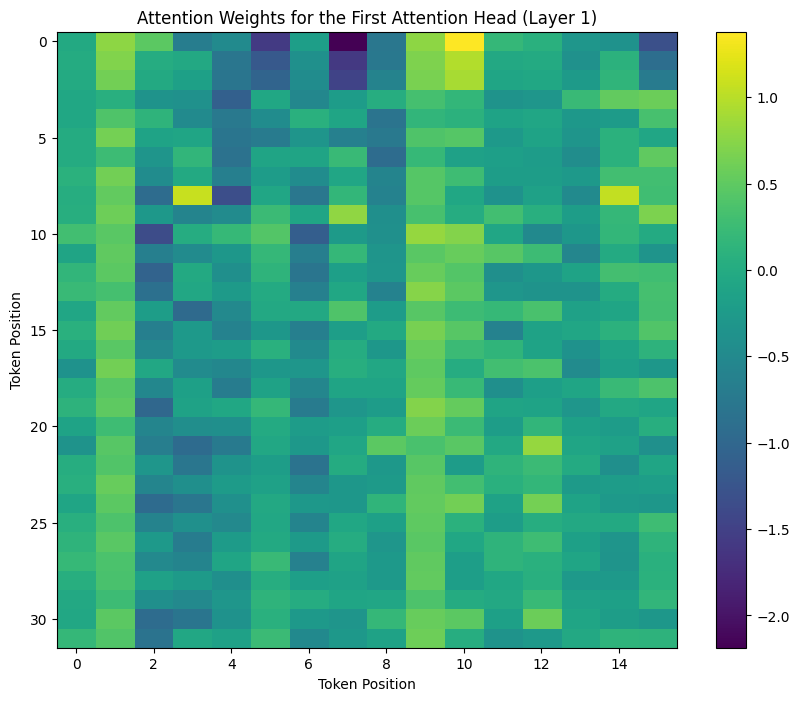

In [ ]:
import matplotlib.pyplot as plt

# Choose an example input sequence to visualize attention
sample_input = torch.randint(0, vocab_size, (1, block_size), device=device)

# Embed the sample input to get the correct shape (B, T, C)
sample_input_embedded = model.token_embedding_table(sample_input)  # (B, T, C)

# Get the output of the model (logits and attention weights) from the first block and first head
# We need to access the attention weights in the first head of the first block
attn_weights = model.blocks[0].sa.heads[0].forward(sample_input_embedded)  # (B, T, C)
attn_weights = attn_weights.detach().cpu().numpy()

# Visualize attention weights for the first attention head
plt.figure(figsize=(10, 8))
plt.imshow(attn_weights[0], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Attention Weights for the First Attention Head (Layer 1)')
plt.xlabel('Token Position')
plt.ylabel('Token Position')
plt.show()

